# **Wrangle and Analyze Data**

## Table of Contents
- [Introduction](#intro)
- [Gathering Data](#gatheringdata)
- [Asses](#asses)
- [Clean](#clean)
- [Visualizing Data](#visualize)

<a id='intro'></a>
## Introduction

Goal of this project is to gather data from a variety of sources and in a variety of formats, assess its quality and tidiness, then clean it. The dataset that will be wrangled (and analyzed and visualized) is the tweet archive of Twitter user @dog_rates, also known as WeRateDogs. WeRateDogs is a Twitter account that rates people's dogs with a humorous comment about the dog.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import requests
import tweepy
from os import path
import re
%matplotlib inline

<a id='gatheringdata'></a>
## Gathering Data

Data was gathered from multiple sources:
1. The WeRateDogs Twitter archive: twitter_archive_enhanced.csv provided for this project
2. The tweet image predictions: what breed of dog (or other object, animal, etc.) is present in each tweet according to a neural network. This file (image_predictions.tsv) is hosted on Udacity's servers and will be downloaded programmatically.
3. Each tweet's entire set of JSON data in a file called tweet_json.txt aquired using tweet IDs in the WeRateDogs Twitter archive



### Load Data

#### WeRateDogs Twitter archive

In [2]:
df_twitter = pd.read_csv('twitter-archive-enhanced.csv')

In [3]:
print(f'Twitter archive loaded into a dataframe of {df_twitter.shape[0]} rows and {df_twitter.shape[1]} columns') 

Twitter archive loaded into a dataframe of 2356 rows and 17 columns


#### Tweet image predictions

In [4]:
if not path.exists('image-predictions.tsv'):
    # Sernding HTTP/1.1 request
    url = ' https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
    response = requests.get(url)
    # Write to file
    with open('image-predictions.tsv', mode ='wb') as file:
        file.write(response.content)

In [5]:
# check if file created and load
if path.exists('image-predictions.tsv'):
    df_img_preds = pd.read_csv('image-predictions.tsv', sep='\t')
    print(f'Image predictions loaded into a dataframe of {df_img_preds.shape[0]} rows and {df_img_preds.shape[1]} columns') 
else:
    print('ERROR: file doesnt exist!')

Image predictions loaded into a dataframe of 2075 rows and 12 columns


#### Tweets entire JSON data

In [6]:
# Connecting to twitter API
def ConnectToTwitterAPI(consumer_key, consumer_secret, access_token, access_secret):
    auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token, access_secret)
    api = tweepy.API(auth)
    return api

def ExtractDataFromApi(tweet_ids):
    # loop through them and extract json data
    tweet_data = []
    for id in tweet_ids:
        try:
            tweet = api.get_status(id, 
                                tweet_mode='extended', 
                                wait_on_rate_limit=True, 
                                Wait_on_rate_limit_notify=True)
            tweet_data.append(tweet)
        except:
            print(f'Unable to grab data for tweet id {id}')
    print(f'Data found for {len(tweet_data)} out of {df_img_preds.shape[0]} tweets')

    return tweet_data

def WriteTweetDataToJsonFile(tweet_data):
    with open('tweet-json.txt', mode = 'w') as file:
        json.dump(tweet_data, file)

def ReadTweetDataFromJsonFile(file):
    with open(file, encoding='utf-8') as json_file:
        data = json.load(json_file)
    print(f'Read {len(data)} json records from {file}')
    return data

def LoadJsonToDataFrame(json_data):
    tweets = []
    for json_tweet in json_data:
        tweets.append({
            'tweet_id' : json_tweet['id'],
            # 'favorited' : json_tweet['favorited'],
            # 'retweeted' : json_tweet['retweeted'],
            'favorite_count' : json_tweet['favorite_count'],
            'retweet_count' : json_tweet['retweet_count'],
            'followers_count' : json_tweet['user']['followers_count'],
            'friends_count' : json_tweet['user']['friends_count'],
            'listed_count' : json_tweet['user']['listed_count'],
            'statuses_count': json_tweet['user']['statuses_count']})
    df_tweets_api = pd.DataFrame(tweets, columns=['tweet_id' , 'favorite_count', 'retweet_count','followers_count','friends_count', 'listed_count', 'statuses_count'])
    
    print(f'Tweet data loaded from api into a dataframe of {df_tweets_api.shape[0]} rows and {df_tweets_api.shape[1]} columns') 
    return df_tweets_api    
        



In [7]:
if not path.exists('tweet-json.txt'):
    consumer_key = 'PNCHaJoIWwIqgmLwUN4y1eWV2'
    consumer_secret = 'S3mGnnYw90IxAVAbdVqvnnLXylkkuczs9QBaoUbGXDak9Rk99s'
    access_token = '1265046638852177922-1TpjAzlCNONthmU6NeprTV9uME4qby'
    access_secret = '3P3ccncdi6O2aqg6uHELMHFJ9QcoaAXbJFzByigj8z6UX'

    api = ConnectToTwitterAPI(consumer_key, consumer_secret, access_token, access_secret)
    # extract all the tweetid
    tweet_ids = df_twitter['tweet_id']
    tweet_data = ExtractDataFromApi(tweet_ids)
    # Write tweet data to json file
    WriteTweetDataToJsonFile(tweet_data)

# Read from json file 
json_data = ReadTweetDataFromJsonFile('tweet-json.txt')
# Load into dataframe
df_tweets_api = LoadJsonToDataFrame(json_data)

Read 2330 json records from tweet-json.txt
Tweet data loaded from api into a dataframe of 2330 rows and 7 columns


<a id='asses'></a>
## Assess

Lets start with the twitter archive loaded into dataframe 

In [8]:
# Take a look at first few rows in dataframe
df_twitter.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
776,776113305656188928,NaN,NaN,2016-09-14 17:40:06 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Sampson. He's about to get hit with a ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/776113305...,11,10,Sampson,None,None,pupper,None
660,791312159183634433,NaN,NaN,2016-10-26 16:14:55 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Mabel. She's super h*ckin smol. Portab...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/791312159...,12,10,Mabel,None,None,None,None
2060,671182547775299584,NaN,NaN,2015-11-30 04:22:44 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This pup holds the secrets of the universe in ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/671182547...,12,10,None,None,None,None,None
1990,672640509974827008,NaN,NaN,2015-12-04 04:56:09 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Leonidas. He just got rekt by a snowba...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/672640509...,9,10,Leonidas,None,None,None,None
227,848324959059550208,NaN,NaN,2017-04-02 00:03:26 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Odin. He's supposed to be giving directio...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/848324959...,12,10,Odin,None,None,None,None


In [9]:
df_twitter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [10]:
df_twitter.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [11]:
df_twitter['tweet_id'].nunique()

2356

Initial observation

1.   Total 2356 tweets
2.   Incomplete columns:
    - in_reply_to_status_id
    - in_reply_to_user_id  
    - retweeted_status_id
    - retweeted_status_user_id
    - retweeted_status_timestamp
    - expanded_urls
3.   Timestame and retweeted_status_timestamp is object not of type DateTime
4.   Source column has html tags present 
5.   Name Column has invalid names such as None
6.   The last 4 columns doggo, floofer, pupper and puppo can instead be a single categorical column
7. Rating numerator and denominator dont seem to fall in valid range of values since their max values are 1776 and 170



Next, lets look at the Tweet image predictions dataframe 

In [12]:
df_img_preds.sample(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
400,673688752737402881,https://pbs.twimg.com/media/CVlsVs3WIAAja6m.jpg,1,soft-coated_wheaten_terrier,0.340806,True,Sealyham_terrier,0.234898,True,kuvasz,0.203495,True
17,666104133288665088,https://pbs.twimg.com/media/CT56LSZWoAAlJj2.jpg,1,hen,0.965932,False,cock,0.033919,False,partridge,0.000052,False
1965,867421006826221569,https://pbs.twimg.com/media/DAmyy8FXYAIH8Ty.jpg,1,Eskimo_dog,0.616457,True,Siberian_husky,0.381330,True,malamute,0.001670,True
833,693942351086120961,https://pbs.twimg.com/media/CaFg41YWkAAdOjy.jpg,1,groenendael,0.550796,True,Norwegian_elkhound,0.154770,True,schipperke,0.080802,True
1349,759566828574212096,https://pbs.twimg.com/media/CkNjahBXAAQ2kWo.jpg,1,Labrador_retriever,0.967397,True,golden_retriever,0.016641,True,ice_bear,0.014858,False


In [13]:
df_img_preds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


Initial Observation:

This dataframe looks complete for the most part and has the correct datatypes for each column. Key here would be how we use it.

1. Inconsistency, the prediction columns p1, p2, p3 do not follow similar case format and are seperated by an underscore. 
2. This data can be combined with tweeter archive dataframe

Finally, the tweets api dataframe

In [14]:
df_tweets_api.head()

,tweet_id,favorite_count,retweet_count,followers_count,friends_count,listed_count,statuses_count
0,892420643555336193,36230,7711,8785083,16,5536,12252
1,892177421306343426,31252,5699,8785083,16,5536,12252
2,891815181378084864,23529,3779,8785083,16,5536,12252
3,891689557279858688,39535,7875,8785083,16,5536,12252
4,891327558926688256,37745,8484,8785083,16,5536,12252


In [15]:
df_tweets_api.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2330 entries, 0 to 2329
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   tweet_id         2330 non-null   int64
 1   favorite_count   2330 non-null   int64
 2   retweet_count    2330 non-null   int64
 3   followers_count  2330 non-null   int64
 4   friends_count    2330 non-null   int64
 5   listed_count     2330 non-null   int64
 6   statuses_count   2330 non-null   int64
dtypes: int64(7)
memory usage: 127.5 KB


In [16]:
df_tweets_api.describe()

,tweet_id,favorite_count,retweet_count,followers_count,friends_count,listed_count,statuses_count
count,2.330000e+03,2330.000000,2330.000000,2.330000e+03,2330.0,2330.000000,2330.0
mean,7.419357e+17,7568.380687,2706.056223,8.785103e+06,16.0,5536.238197,12252.0
std,6.823308e+16,11746.852715,4575.752360,6.318969e+01,0.0,0.426072,0.0
min,6.660209e+17,0.000000,1.000000,8.785082e+06,16.0,5536.000000,12252.0
25%,6.782926e+17,1318.250000,547.000000,8.785084e+06,16.0,5536.000000,12252.0
50%,7.183508e+17,3289.000000,1269.500000,8.785096e+06,16.0,5536.000000,12252.0
75%,7.986712e+17,9264.000000,3146.750000,8.785101e+06,16.0,5536.000000,12252.0
max,8.924206e+17,156352.000000,77862.000000,8.785742e+06,16.0,5537.000000,12252.0


### Issues Detected 

**Data Quality Issue**
- Convert tweet_id from integer to string
- Remove retweets
- Remove unwanted columns
- Convert timestamp to datetime format
- Transform dog names to match same case preference
- Remove HTML tags from source column
- Fix ratings numerator and denominator
- Create a rating column using the numerator and denominator so it is easy to compare one dog
- Add column dog_breed to predictions data frame based on predictions

**Data Tidiness Issue**
- Consolidating dog type to 1 column
- Drop unwanted columns from df_img_preds and df_tweets_api then merge with df_twitter_clean

<a id='clean'></a>
# Clean

In [17]:
df_twitter_clean = df_twitter.copy()
df_img_preds_clean = df_img_preds.copy()
df_tweets_api_clean = df_tweets_api.copy() 

## Quality Issue 1

**Define:** Convert tweet_id from integer to string

**Code:** Use astype() function to set a new type to exisiting column

In [18]:
df_twitter_clean['tweet_id'] = df_twitter_clean['tweet_id'].astype(str)
df_img_preds_clean['tweet_id'] = df_img_preds_clean['tweet_id'].astype(str)
df_tweets_api_clean['tweet_id'] = df_tweets_api_clean['tweet_id'].astype(str)

**Test:** Review dataframe information for datatype

In [19]:
df_twitter_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   object 
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

## Quality Issue 2

**Define:** Remove retweets

We acheive this by removing any column where retweet status id is not null

**Code:** Find all indices where retweeted_status_id is NaN

In [20]:
df_twitter_clean = df_twitter_clean[np.isnan(df_twitter_clean.retweeted_status_id)]

**Test:** We will verify the DataFrame information to check if all retweeted variables non-null count should be 0

In [21]:
df_twitter_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2175 non-null   object 
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2175 non-null   object 
 4   source                      2175 non-null   object 
 5   text                        2175 non-null   object 
 6   retweeted_status_id         0 non-null      float64
 7   retweeted_status_user_id    0 non-null      float64
 8   retweeted_status_timestamp  0 non-null      object 
 9   expanded_urls               2117 non-null   object 
 10  rating_numerator            2175 non-null   int64  
 11  rating_denominator          2175 non-null   int64  
 12  name                        2175 non-null   object 
 13  doggo                       2175 

## Tidiness Issue 1

**Define:** Consolidating dog type to 1 column

Dog types are: 
doggo', 'floofer', 'pupper', 'puppo'

These columns were originally created by extracting from the text associated with each tweet

In [22]:
# First of all set the None value with blank ' ' 
dog_stages = ['pupper', 'doggo', 'puppo', 'floofer']
for stage in dog_stages:
    df_twitter_clean[stage].replace('None','',inplace=True)

**Code:** using vectorization add them and  then, multiple dog stages are set as comma separated

In [23]:
df_twitter_clean['dog_stage']=df_twitter_clean['doggo']+df_twitter_clean['floofer']+df_twitter_clean['pupper']+df_twitter_clean['puppo']

In [24]:
df_twitter_clean['dog_stage'].value_counts()

                1831
pupper           224
doggo             75
puppo             24
doggopupper       10
floofer            9
doggofloofer       1
doggopuppo         1
Name: dog_stage, dtype: int64

In [25]:
for stage in dog_stages:
    for stage2 in dog_stages:
        string_to_search = stage + stage2
        string_to_assign = stage + ',' + stage2
        print(f'Searching for: {string_to_search} and replacing with: {string_to_assign}')
        df_twitter_clean.loc[df_twitter_clean.dog_stage==string_to_search,'dog_stage']=string_to_assign

Searching for: pupperpupper and replacing with: pupper,pupper
Searching for: pupperdoggo and replacing with: pupper,doggo
Searching for: pupperpuppo and replacing with: pupper,puppo
Searching for: pupperfloofer and replacing with: pupper,floofer
Searching for: doggopupper and replacing with: doggo,pupper
Searching for: doggodoggo and replacing with: doggo,doggo
Searching for: doggopuppo and replacing with: doggo,puppo
Searching for: doggofloofer and replacing with: doggo,floofer
Searching for: puppopupper and replacing with: puppo,pupper
Searching for: puppodoggo and replacing with: puppo,doggo
Searching for: puppopuppo and replacing with: puppo,puppo
Searching for: puppofloofer and replacing with: puppo,floofer
Searching for: flooferpupper and replacing with: floofer,pupper
Searching for: flooferdoggo and replacing with: floofer,doggo
Searching for: flooferpuppo and replacing with: floofer,puppo
Searching for: flooferfloofer and replacing with: floofer,floofer


**Test:** Verify if new column is created and matches the previous inidvidual dog type columns

In [26]:
df_twitter_clean['dog_stage'].value_counts()

                 1831
pupper            224
doggo              75
puppo              24
doggo,pupper       10
floofer             9
doggo,puppo         1
doggo,floofer       1
Name: dog_stage, dtype: int64

Since 1831 rows have an empty string, its too large of a number to drop all those rows so for now we keep them. 

In [27]:
df_twitter_clean[['doggo', 'floofer', 'pupper', 'puppo', 'dog_stage']].sample(10)

,doggo,floofer,pupper,puppo,dog_stage
934,,,,,
2119,,,,,
1262,,,,,
59,,,,,
2232,,,,,
1635,,,,,
952,,,,,
641,,,,,
1441,,,pupper,,pupper
1051,doggo,,,,doggo


## Quality Issue 3
**Define:** Remove unwanted columns

Since we removed all rows which were retweets, we can remove columns relating to retweet as well as others which dont think are relevant

**Code:** A this point we can drop these columns as they serve no purpose.

In [28]:
columns_to_drop = ['retweeted_status_id', 
                   'retweeted_status_user_id', 
                   'retweeted_status_timestamp',
                   'in_reply_to_status_id', 
                   'in_reply_to_user_id',
                   'doggo', 
                   'floofer', 
                   'pupper', 
                   'puppo']
df_twitter_clean = df_twitter_clean.drop(columns_to_drop, axis=1)

**Test:** Lets take a look at the dataframe once again and what we are left with now

In [29]:
df_twitter_clean.head(3)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage
0,892420643555336193,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,
1,892177421306343426,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,
2,891815181378084864,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,


In [30]:
df_twitter_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_id            2175 non-null   object
 1   timestamp           2175 non-null   object
 2   source              2175 non-null   object
 3   text                2175 non-null   object
 4   expanded_urls       2117 non-null   object
 5   rating_numerator    2175 non-null   int64 
 6   rating_denominator  2175 non-null   int64 
 7   name                2175 non-null   object
 8   dog_stage           2175 non-null   object
dtypes: int64(2), object(7)
memory usage: 169.9+ KB


## Quality Issue 4

**Define:** Convert timestamp to datetime format

**Code:** Use pandas to_datatime() function

In [31]:
df_twitter_clean['timestamp'].sample(5)

218     2017-04-07 13:04:55 +0000
1466    2016-02-02 02:10:14 +0000
1997    2015-12-04 01:40:29 +0000
2142    2015-11-26 20:12:29 +0000
1757    2015-12-21 02:30:45 +0000
Name: timestamp, dtype: object

First we would need to clean up the format so it can be accepted by the function

In [32]:
# test
df_twitter_clean.sample(1)['timestamp'].str.slice(start=0, stop=-6)

607    2016-11-14 17:03:50
Name: timestamp, dtype: object

In [33]:
# apply
df_twitter_clean['timestamp'] = df_twitter_clean['timestamp'].str.slice(start=0, stop=-6)
df_twitter_clean['timestamp'] = pd.to_datetime(df_twitter_clean['timestamp'], format = "%Y-%m-%d %H:%M:%S")

**Test:** lets take a look at the dataframe information if the change has been applied. we expect to see the DateTime as the datatype for timestamp column

In [34]:
df_twitter_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   tweet_id            2175 non-null   object        
 1   timestamp           2175 non-null   datetime64[ns]
 2   source              2175 non-null   object        
 3   text                2175 non-null   object        
 4   expanded_urls       2117 non-null   object        
 5   rating_numerator    2175 non-null   int64         
 6   rating_denominator  2175 non-null   int64         
 7   name                2175 non-null   object        
 8   dog_stage           2175 non-null   object        
dtypes: datetime64[ns](1), int64(2), object(6)
memory usage: 169.9+ KB


## Quality Issue 5

**Define:** Transform dog names to match same case preference 

**Code:** We use regular expression to capitalize the first letter in all names

In [35]:
df_twitter_clean.name = df_twitter_clean.name.str.replace('^[a-z]+', 'None')

**Test:** Verify a random sample to check if the names appear correct now

In [36]:
df_twitter_clean.sample(10)['name']

2087    Trigger
993        None
1815       None
1706       None
1871       None
1816       None
827      DonDon
1434    Bentley
1097       None
1494    Chester
Name: name, dtype: object

## Quality Issue 6

**Define**: Remove HTML tags from source column

**Code**: Use regular expression to extract the html tag content

In [37]:
source_str = df_twitter_clean.sample(1)['source'].iloc[0]
source_modified = re.findall(r'>(.*)<', df_twitter_clean.sample(1)['source'].iloc[0])[0]
print(f'Before: {source_str}')
print(f'After: {source_modified}')

Before: <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>
After: Vine - Make a Scene


In [38]:
# apply to entire column
df_twitter_clean['source'] = df_twitter_clean['source'].apply(lambda x: re.findall(r'>(.*)<', x)[0])

**Test:** Verify the dataframe sorce column

In [39]:
df_twitter_clean.sample(10)['source']

2354    Twitter for iPhone
1573    Twitter for iPhone
704     Twitter for iPhone
1817    Twitter for iPhone
346     Twitter for iPhone
1701    Twitter for iPhone
2349    Twitter for iPhone
1962    Twitter for iPhone
1977    Twitter for iPhone
92      Twitter for iPhone
Name: source, dtype: object

In [40]:
df_twitter_clean['source'].value_counts()

Twitter for iPhone     2042
Vine - Make a Scene      91
Twitter Web Client       31
TweetDeck                11
Name: source, dtype: int64

## Quality Issue 7

**Define:** Fix ratings numerator and denominator

**Code:** First lets change the data format for numerator and denominator to be a float




In [41]:
df_twitter_clean['rating_numerator'] = df_twitter_clean['rating_numerator'].astype(float)
df_twitter_clean['rating_denominator'] = df_twitter_clean['rating_denominator'].astype(float)

Next, we will search the text column for numerators with decimal point

In [42]:
# have a look at one of the text fields to create regex pattern
temp_text = df_twitter_clean.sample(1)['text'].iloc[0]
print(temp_text)

This is Misty. She has a cowboy hat on her nose. 12/10 https://t.co/Eno0mypHIr


In [43]:
# first we try to searh without a decimal point since that is more common
result = re.search('\d+\/\d+', temp_text)
print(result)

<_sre.SRE_Match object; span=(49, 54), match='12/10'>


In [44]:
bool(result)

True

In [45]:
result.group()

'12/10'

In [46]:
# Search for the index of rows with decimal in ratings numerator
decimal_rating_index=[]
decimal_rating_values=[]
for index, row in df_twitter_clean.iterrows():
    text = row['text']
    result = re.search('\d+\.\d+\/\d+', text)
    if bool(result):
        decimal_rating_index.append(index)
        decimal_rating_values.append(result.group())
        print(index, ': ', result.group(), ', ', text)

45 :  13.5/10 ,  This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948
695 :  9.75/10 ,  This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS
763 :  11.27/10 ,  This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq
1689 :  9.5/10 ,  I've been told there's a slight possibility he's checking his mirror. We'll bump to 9.5/10. Still a menace
1712 :  11.26/10 ,  Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD


In [47]:
for i, index in enumerate(decimal_rating_index):
    num_splits = decimal_rating_values[i].split('/')
    print(num_splits)
    df_twitter_clean.loc[index,'rating_numerator'] = float(num_splits[0])
    df_twitter_clean.loc[index,'rating_denominator'] = float(num_splits[1])

['13.5', '10']
['9.75', '10']
['11.27', '10']
['9.5', '10']
['11.26', '10']


In [48]:
float(num_splits[1])

10.0

**Test:** Verify numerator and denominator values in the rows affected

In [49]:
for index in decimal_rating_index:
    print(df_twitter_clean.loc[index])
    print('-----------------------------------------------------------------------')

tweet_id                                             883482846933004288
timestamp                                           2017-07-08 00:28:19
source                                               Twitter for iPhone
text                  This is Bella. She hopes her smile made you sm...
expanded_urls         https://twitter.com/dog_rates/status/883482846...
rating_numerator                                                   13.5
rating_denominator                                                   10
name                                                              Bella
dog_stage                                                              
Name: 45, dtype: object
-----------------------------------------------------------------------
tweet_id                                             786709082849828864
timestamp                                           2016-10-13 23:23:56
source                                               Twitter for iPhone
text                  This is Logan, the

In [50]:
df_twitter_clean.describe()

,rating_numerator,rating_denominator
count,2175.000000,2175.000000
mean,13.177140,10.492874
std,47.705088,7.019084
min,0.000000,0.000000
25%,10.000000,10.000000
50%,11.000000,10.000000
75%,12.000000,10.000000
max,1776.000000,170.000000


In [51]:
df_twitter_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   tweet_id            2175 non-null   object        
 1   timestamp           2175 non-null   datetime64[ns]
 2   source              2175 non-null   object        
 3   text                2175 non-null   object        
 4   expanded_urls       2117 non-null   object        
 5   rating_numerator    2175 non-null   float64       
 6   rating_denominator  2175 non-null   float64       
 7   name                2175 non-null   object        
 8   dog_stage           2175 non-null   object        
dtypes: datetime64[ns](1), float64(2), object(6)
memory usage: 249.9+ KB


## Quality Issue 8

**Define:** Create a rating column using the numerator and denominator so it is easy to compare one dog against another irrespective of their rating scale

**Code:** We devide numerator with denominator and assign to new column

In [52]:
df_twitter_clean['rating'] = df_twitter_clean['rating_numerator'] / df_twitter_clean['rating_denominator']

**Test:** Sample the dataframe and view the new column

In [53]:
df_twitter_clean.sample(5)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,rating
781,775729183532220416,2016-09-13 16:13:44,Twitter for iPhone,This girl straight up rejected a guy because h...,https://twitter.com/dog_rates/status/775729183...,13.0,10.0,None,,1.3
2348,666055525042405380,2015-11-16 00:49:46,Twitter for iPhone,Here is a Siberian heavily armored polar bear ...,https://twitter.com/dog_rates/status/666055525...,10.0,10.0,None,,1.0
1918,674271431610523648,2015-12-08 16:56:51,Twitter for iPhone,"""AT DAWN, WE RIDE""\n10/10 for both dogs https:...",https://twitter.com/dog_rates/status/674271431...,10.0,10.0,None,,1.0
1746,679132435750195208,2015-12-22 02:52:45,Twitter for iPhone,This is Louis. He's a river dancer. His friend...,https://twitter.com/dog_rates/status/679132435...,10.0,10.0,Louis,,1.0
1772,678278586130948096,2015-12-19 18:19:51,Twitter for iPhone,Another spooky pupper here. Most definitely fl...,https://twitter.com/dog_rates/status/678278586...,10.0,10.0,None,pupper,1.0


## Quality Issue 9
**Define:** Add column dog_breed to predictions data frame based on predictions 

**Code:** Consolidate the predictions and their repective probablitiy to one dog_breed column

In [54]:
dog_breed = []
for i, row in df_img_preds_clean.iterrows():
    if row['p1_dog']:
        dog_breed.append(row.p1)
    elif row['p2_dog']:
        dog_breed.append(row.p2)
    elif row['p3_dog']:
        dog_breed.append(row.p3)
    else:
        dog_breed.append('None')
        
df_img_preds_clean['dog_breed'] = dog_breed

**Test**: Sample the dataframe as well its summary information to look at the newly created column

In [55]:
df_img_preds_clean.sample(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,dog_breed
1095,720043174954147842,https://pbs.twimg.com/media/Cf4bcm8XEAAX4xV.jpg,1,Samoyed,0.954517,True,Eskimo_dog,0.029130,True,white_wolf,0.004462,False,Samoyed
504,675888385639251968,https://pbs.twimg.com/media/CWE85snWIAEG5ES.jpg,1,West_Highland_white_terrier,0.672117,True,Old_English_sheepdog,0.146147,True,komondor,0.023141,True,West_Highland_white_terrier
1017,709918798883774466,https://pbs.twimg.com/media/CdojYQmW8AApv4h.jpg,2,Pembroke,0.956222,True,Cardigan,0.020727,True,Chihuahua,0.007912,True,Pembroke
17,666104133288665088,https://pbs.twimg.com/media/CT56LSZWoAAlJj2.jpg,1,hen,0.965932,False,cock,0.033919,False,partridge,0.000052,False,None
1741,822610361945911296,https://pbs.twimg.com/media/C2p_wQyXEAELtvS.jpg,1,cocker_spaniel,0.664487,True,Norfolk_terrier,0.075089,True,Norwich_terrier,0.059644,True,cocker_spaniel


In [56]:
df_img_preds_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   tweet_id   2075 non-null   object 
 1   jpg_url    2075 non-null   object 
 2   img_num    2075 non-null   int64  
 3   p1         2075 non-null   object 
 4   p1_conf    2075 non-null   float64
 5   p1_dog     2075 non-null   bool   
 6   p2         2075 non-null   object 
 7   p2_conf    2075 non-null   float64
 8   p2_dog     2075 non-null   bool   
 9   p3         2075 non-null   object 
 10  p3_conf    2075 non-null   float64
 11  p3_dog     2075 non-null   bool   
 12  dog_breed  2075 non-null   object 
dtypes: bool(3), float64(3), int64(1), object(6)
memory usage: 168.3+ KB


## Tidiness Issue 2

**Define:** Drop unwanted columns from df_img_preds and df_tweets_api then merge with df_twitter_clean

Droping unwanted columns

In [57]:
df_img_preds_clean.drop(columns=['img_num'], inplace=True)

**Code**: Use pandas merge function on tweet_id column

In [58]:
df_tweets_dogs = df_twitter_clean.merge(df_img_preds_clean, on='tweet_id', how='inner')

In [59]:
df_tweets_dogs = df_tweets_dogs.merge(df_tweets_api_clean, on='tweet_id', how='inner')

**Test**: Sample the dataframe and ensure all columns look correctly merged

In [60]:
df_tweets_dogs.sample(5)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,rating,...,p3,p3_conf,p3_dog,dog_breed,favorite_count,retweet_count,followers_count,friends_count,listed_count,statuses_count
799,739932936087216128,2016-06-06 21:32:13,Twitter for iPhone,Say hello to Rorie. She's zen af. Just enjoyin...,https://twitter.com/dog_rates/status/739932936...,10.0,10.0,Rorie,,1.0,...,vizsla,0.076443,True,redbone,4048,1070,8785096,16,5536,12252
1160,693622659251335168,2016-01-31 02:31:43,Twitter for iPhone,When you keepin the popcorn bucket in your lap...,https://twitter.com/dog_rates/status/693622659...,10.0,10.0,None,,1.0,...,Eskimo_dog,0.163485,True,malamute,1532,372,8785097,16,5536,12252
1756,670411370698022913,2015-11-28 01:18:21,Twitter for iPhone,Meet Scooter. He's ready for his first day of ...,https://twitter.com/dog_rates/status/670411370...,12.0,10.0,Scooter,,1.2,...,toy_poodle,0.060868,True,Maltese_dog,1949,848,8785115,16,5537,12252
1296,684225744407494656,2016-01-05 04:11:44,Twitter for iPhone,"Two sneaky puppers were not initially seen, mo...",https://twitter.com/dog_rates/status/684225744...,143.0,130.0,None,,1.1,...,Great_Pyrenees,0.065327,True,golden_retriever,1222,207,8785100,16,5536,12252
891,720415127506415616,2016-04-14 00:55:25,Twitter for iPhone,Garden's coming in nice this year. 10/10 https...,https://twitter.com/dog_rates/status/720415127...,10.0,10.0,None,,1.0,...,American_black_bear,0.001733,False,Rottweiler,4099,1490,8785095,16,5536,12252


In [61]:
df_tweets_dogs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1986 entries, 0 to 1985
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   tweet_id            1986 non-null   object        
 1   timestamp           1986 non-null   datetime64[ns]
 2   source              1986 non-null   object        
 3   text                1986 non-null   object        
 4   expanded_urls       1986 non-null   object        
 5   rating_numerator    1986 non-null   float64       
 6   rating_denominator  1986 non-null   float64       
 7   name                1986 non-null   object        
 8   dog_stage           1986 non-null   object        
 9   rating              1986 non-null   float64       
 10  jpg_url             1986 non-null   object        
 11  p1                  1986 non-null   object        
 12  p1_conf             1986 non-null   float64       
 13  p1_dog              1986 non-null   bool        

# Storing Data

In [62]:
# storing the dataframe to a csv file
df_tweets_dogs.to_csv('df_tweets_dogs.csv', encoding='utf-8', index=False)

<a id='visualize'></a>
# Visualizing Data 

## Visualization 1

Total number of tweet over time

In [63]:
# first begin by grouping the data monthly
df_monthly = df_tweets_dogs.groupby(pd.Grouper(key = 'timestamp', freq = "M")).count().reset_index()
# Review the new dataframe
df_monthly.head()

,timestamp,tweet_id,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,rating,...,p3,p3_conf,p3_dog,dog_breed,favorite_count,retweet_count,followers_count,friends_count,listed_count,statuses_count
0,2015-11-30,296,296,296,296,296,296,296,296,296,...,296,296,296,296,296,296,296,296,296,296
1,2015-12-31,365,365,365,365,365,365,365,365,365,...,365,365,365,365,365,365,365,365,365,365
2,2016-01-31,169,169,169,169,169,169,169,169,169,...,169,169,169,169,169,169,169,169,169,169
3,2016-02-29,111,111,111,111,111,111,111,111,111,...,111,111,111,111,111,111,111,111,111,111
4,2016-03-31,120,120,120,120,120,120,120,120,120,...,120,120,120,120,120,120,120,120,120,120


In [64]:
df_monthly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22 entries, 0 to 21
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   timestamp           22 non-null     datetime64[ns]
 1   tweet_id            22 non-null     int64         
 2   source              22 non-null     int64         
 3   text                22 non-null     int64         
 4   expanded_urls       22 non-null     int64         
 5   rating_numerator    22 non-null     int64         
 6   rating_denominator  22 non-null     int64         
 7   name                22 non-null     int64         
 8   dog_stage           22 non-null     int64         
 9   rating              22 non-null     int64         
 10  jpg_url             22 non-null     int64         
 11  p1                  22 non-null     int64         
 12  p1_conf             22 non-null     int64         
 13  p1_dog              22 non-null     int64         
 

Text(0, 0.5, 'Twwet Count')

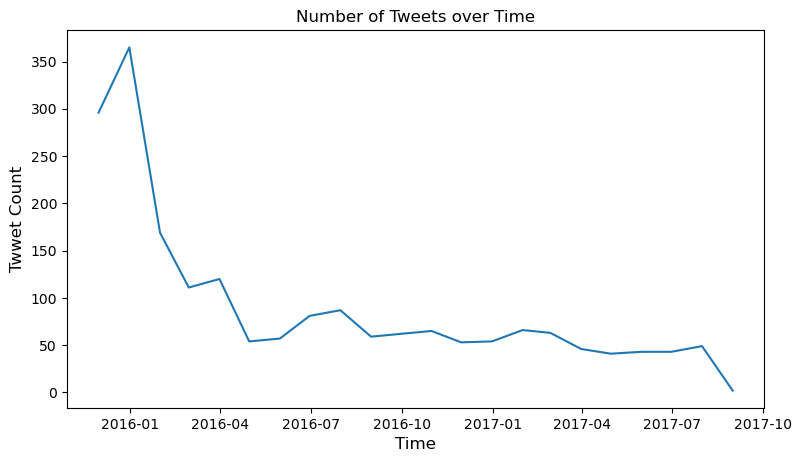

In [65]:
plt.figure(figsize=(9,5), dpi = 100)
plt.plot(df_monthly.timestamp,df_monthly.tweet_id)
plt.title('Number of Tweets over Time')
plt.xlabel('Time', fontsize=12)
plt.ylabel('Twwet Count', fontsize=12)

Overall, there is a downward trend in number of tweets per month. There are few times when an increase in monthly tweets was observed. This seemed to happen between 2016-04 to 2016-10. A plausible reason for this decline could be due to emergence of new social media platforms.

## Visualization 2

Most popular Dog Breeds

In [66]:
# group by dog breeds and only consider ones which have a count greater than 20
df_dog_breed = df_tweets_dogs.groupby('dog_breed').filter(lambda x: len(x) >= 20)

df_dog_breed.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,rating,...,p3,p3_conf,p3_dog,dog_breed,favorite_count,retweet_count,followers_count,friends_count,listed_count,statuses_count
0,892420643555336193,2017-08-01 16:23:56,Twitter for iPhone,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13.0,10.0,Phineas,,1.3,...,banana,0.076110,False,None,36230,7711,8785083,16,5536,12252
1,892177421306343426,2017-08-01 00:17:27,Twitter for iPhone,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13.0,10.0,Tilly,,1.3,...,papillon,0.068957,True,Chihuahua,31252,5699,8785083,16,5536,12252
2,891815181378084864,2017-07-31 00:18:03,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12.0,10.0,Archie,,1.2,...,kelpie,0.031379,True,Chihuahua,23529,3779,8785083,16,5536,12252
3,891689557279858688,2017-07-30 15:58:51,Twitter for iPhone,This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13.0,10.0,Darla,,1.3,...,spatula,0.040836,False,Labrador_retriever,39535,7875,8785083,16,5536,12252
5,891087950875897856,2017-07-29 00:08:17,Twitter for iPhone,Here we have a majestic great white breaching ...,https://twitter.com/dog_rates/status/891087950...,13.0,10.0,None,,1.3,...,Indian_elephant,0.076902,False,Chesapeake_Bay_retriever,19006,2843,8785083,16,5536,12252


In [67]:
dog_breed_counts = df_dog_breed['dog_breed'].value_counts()
dog_breed_counts.drop(index='None', inplace=True)
dog_breed_counts

golden_retriever             158
Labrador_retriever           106
Pembroke                      95
Chihuahua                     91
pug                           62
toy_poodle                    50
chow                          48
Pomeranian                    42
Samoyed                       41
malamute                      32
Chesapeake_Bay_retriever      31
French_bulldog                30
cocker_spaniel                30
miniature_pinscher            25
Eskimo_dog                    22
German_shepherd               21
Cardigan                      21
beagle                        20
Shih-Tzu                      20
Staffordshire_bullterrier     20
Siberian_husky                20
Name: dog_breed, dtype: int64

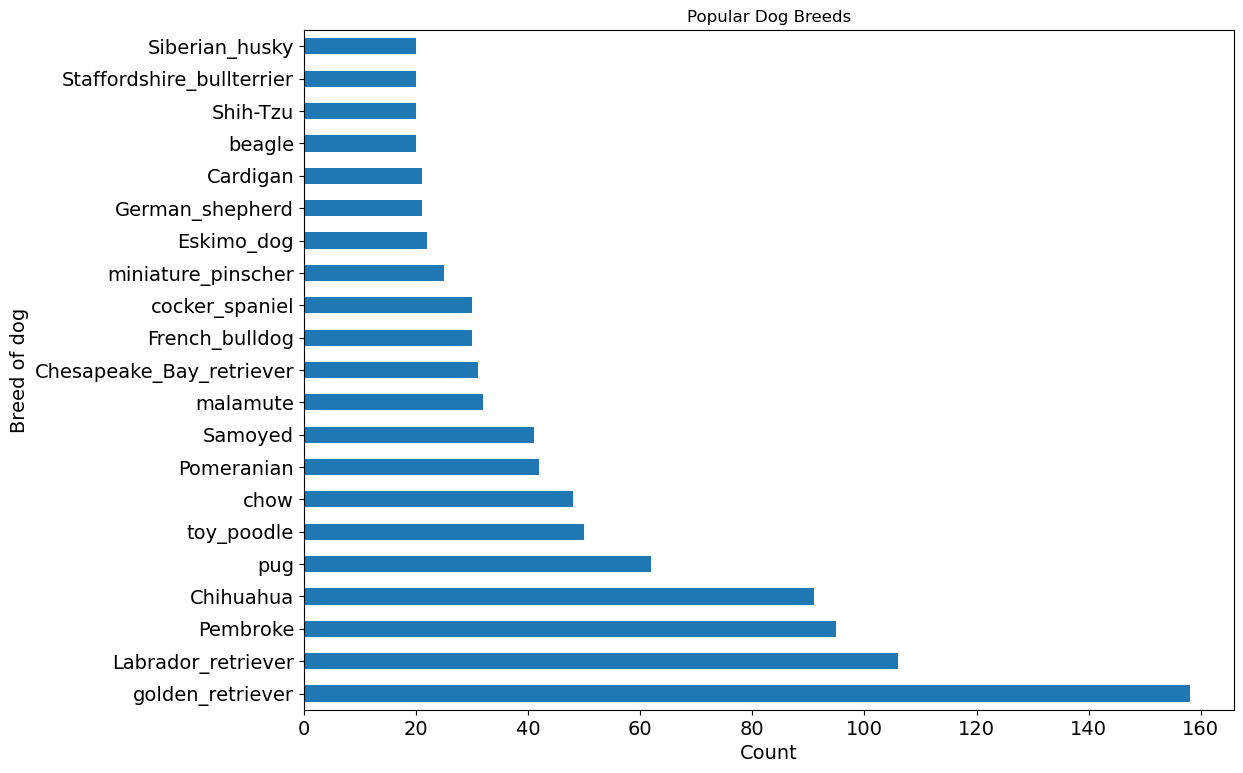

In [68]:
plt.figure(figsize=(12,9), dpi = 100)

dog_breed_counts.plot(kind = 'barh', fontsize=14)
plt.title('Popular Dog Breeds')
plt.xlabel('Count', fontsize=14)
plt.ylabel('Breed of dog', fontsize=14);

fig = plt.gcf() 
fig.savefig('Popular_Dog_Breeds.png',bbox_inches='tight');

Golden retrievers are by far the most popular breed followed by Labrador retriever and Pembroke. This is based on the number of times each dog was tweeted about.

## Visualization 3



Ratings Distribution

In [69]:
df_tweets_dogs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1986 entries, 0 to 1985
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   tweet_id            1986 non-null   object        
 1   timestamp           1986 non-null   datetime64[ns]
 2   source              1986 non-null   object        
 3   text                1986 non-null   object        
 4   expanded_urls       1986 non-null   object        
 5   rating_numerator    1986 non-null   float64       
 6   rating_denominator  1986 non-null   float64       
 7   name                1986 non-null   object        
 8   dog_stage           1986 non-null   object        
 9   rating              1986 non-null   float64       
 10  jpg_url             1986 non-null   object        
 11  p1                  1986 non-null   object        
 12  p1_conf             1986 non-null   float64       
 13  p1_dog              1986 non-null   bool        

c:\users\allay.desai.21csw\appdata\local\conda\conda\envs\data\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


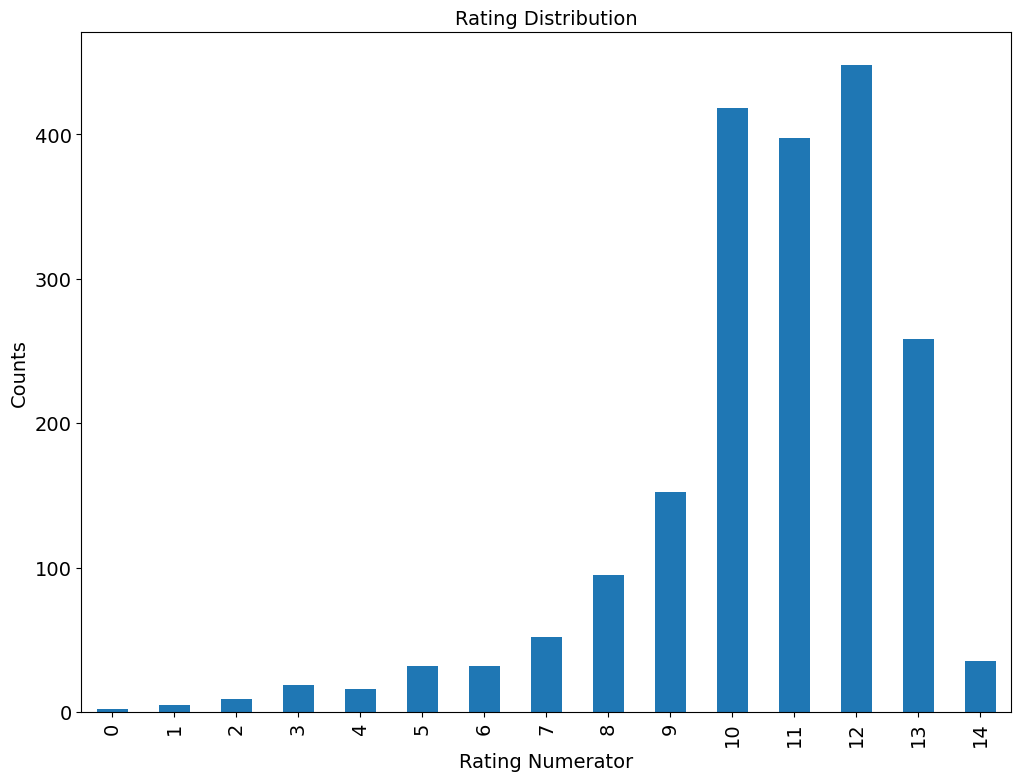

In [70]:
df_tweets_rating = df_tweets_dogs.query('rating_numerator <= 14');
df_tweets_rating['rating_numerator'] = df_tweets_rating['rating_numerator'].astype('int');
rating_counts = df_tweets_rating.groupby(['rating_numerator']).count()['tweet_id'];
plt.figure(figsize=(12,9), dpi = 100);
rating_counts.plot(kind='bar', fontsize=14);
plt.xlabel('Rating Numerator', fontsize=14);
plt.ylabel('Counts', fontsize=14);
plt.title('Rating Distribution', fontsize=14);

plt.savefig('common_ratings.png')

The distribution of dog ratings numerator seems to be skewed to the right. Once again this is to be expected as dogs who are popular or have higher ratings are the ones who are frequently tweeted about.

## Visualization 4

Most Common Dog Name

In [71]:
name_counts= df_tweets_dogs['name'].value_counts()
name_counts = name_counts[:10]
name_counts.drop(index='None', inplace=True)
name_counts

Charlie    10
Oliver     10
Lucy        9
Cooper      9
Tucker      9
Penny       9
Winston     8
Sadie       8
Lola        7
Name: name, dtype: int64

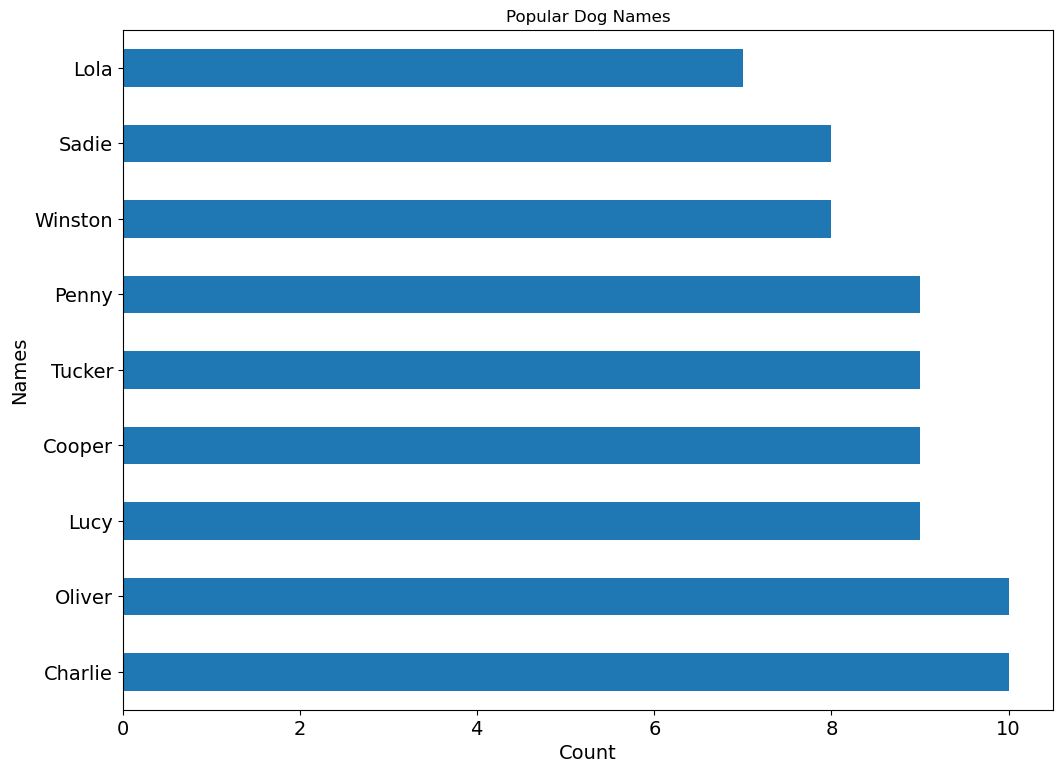

In [72]:
plt.figure(figsize=(12,9), dpi = 100)
name_counts.plot(kind = 'barh', fontsize=14)
plt.title('Popular Dog Names')
plt.xlabel('Count', fontsize=14)
plt.ylabel('Names', fontsize=14);

fig = plt.gcf() 
fig.savefig('Popular_Dog_Names.png',bbox_inches='tight');

It is quite interesting to observe the most common names of dogs being tweeted. The top 10 choices are pretty close with not much differentiate between them in terms of counts. One would have assumes certain names are way more common then others. But data shows that there is plenty of variety when it comes to name choice.

## Visualization 5

Explore the relationship between Retweets and Likes

In [73]:
df_tweets_api_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2330 entries, 0 to 2329
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   tweet_id         2330 non-null   object
 1   favorite_count   2330 non-null   int64 
 2   retweet_count    2330 non-null   int64 
 3   followers_count  2330 non-null   int64 
 4   friends_count    2330 non-null   int64 
 5   listed_count     2330 non-null   int64 
 6   statuses_count   2330 non-null   int64 
dtypes: int64(6), object(1)
memory usage: 127.5+ KB


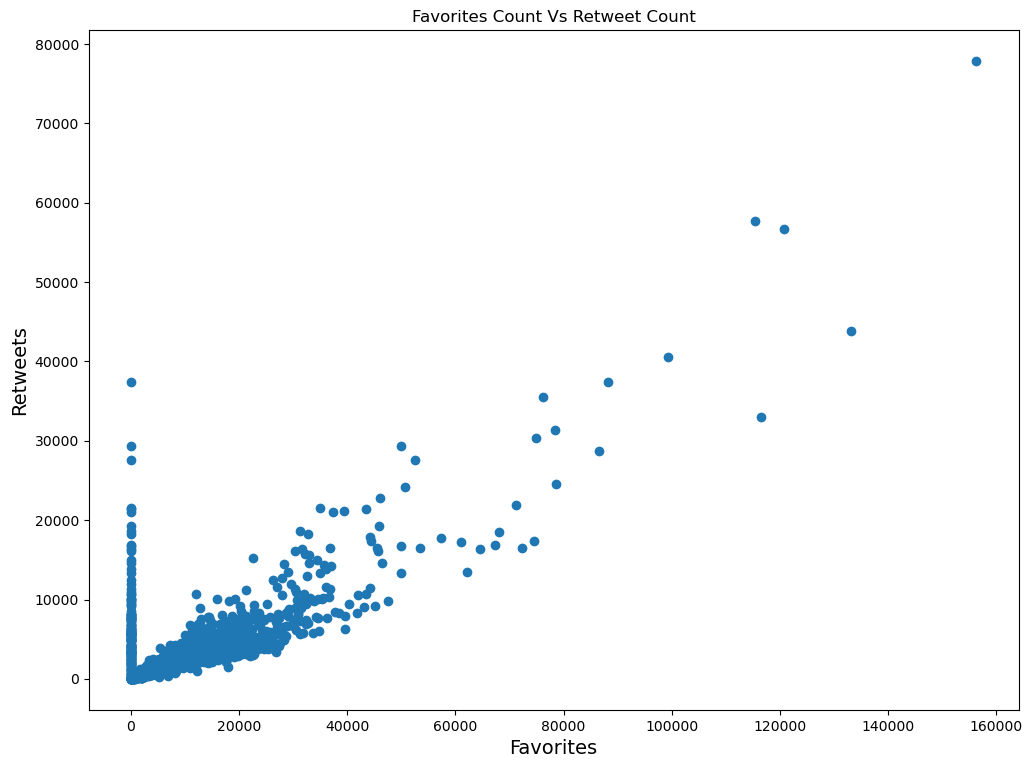

In [74]:
plt.figure(figsize=(12,9), dpi = 100)
plt.scatter(x=df_tweets_api_clean['favorite_count'],y=df_tweets_api_clean['retweet_count'])
plt.title('Favorites Count Vs Retweet Count')
plt.xlabel('Favorites', fontsize=14)
plt.ylabel('Retweets', fontsize=14);

fig = plt.gcf() 
fig.savefig('Favorites_Retweets.png',bbox_inches='tight');

We observe a strong positive trend between retweets count and favorite(like) counts. This is to be expected as most people who favorite a tweet tend to retweet it.